In [26]:
# Import necessary libraries
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Initialize Spark Session with the legacy time parser policy
spark = SparkSession.builder \
    .appName("Twitter Big Data Analysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

# Display Spark session info
spark


In [28]:
# Load the dataset
file_path = "/content/Twitter_Dataset.csv"  # Path to the uploaded dataset
df = spark.read.csv(file_path, header=False, inferSchema=True)

# Rename columns based on inferred structure
df = df.toDF("Target", "ID", "Date", "Query", "User", "OriginalTweet")

# Display schema and a few rows
df.printSchema()
df.show(5)


root
 |-- Target: integer (nullable = true)
 |-- ID: long (nullable = true)
 |-- Date: string (nullable = true)
 |-- Query: string (nullable = true)
 |-- User: string (nullable = true)
 |-- OriginalTweet: string (nullable = true)

+------+----------+--------------------+--------+---------------+--------------------+
|Target|        ID|                Date|   Query|           User|       OriginalTweet|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+------+----------+--------------------+--------+---------------+--------

In [29]:
from pyspark.sql.functions import col, to_timestamp

# Select relevant columns
columns_to_keep = ["Target", "Date", "User", "OriginalTweet"]
df_cleaned = df.select(*columns_to_keep)

# Convert 'Date' to a proper timestamp format using the legacy parser
df_cleaned = df_cleaned.withColumn("timestamp", to_timestamp(col("Date"), "EEE MMM dd HH:mm:ss z yyyy"))

# Drop rows with missing values in important columns
df_cleaned = df_cleaned.na.drop()

# Show the cleaned data
df_cleaned.show(5)

# Confirm the schema
df_cleaned.printSchema()


+------+--------------------+---------------+--------------------+-------------------+
|Target|                Date|           User|       OriginalTweet|          timestamp|
+------+--------------------+---------------+--------------------+-------------------+
|     0|Mon Apr 06 22:19:...|_TheSpecialOne_|@switchfoot http:...|2009-04-07 05:19:45|
|     0|Mon Apr 06 22:19:...|  scotthamilton|is upset that he ...|2009-04-07 05:19:49|
|     0|Mon Apr 06 22:19:...|       mattycus|@Kenichan I dived...|2009-04-07 05:19:53|
|     0|Mon Apr 06 22:19:...|        ElleCTF|my whole body fee...|2009-04-07 05:19:57|
|     0|Mon Apr 06 22:19:...|         Karoli|@nationwideclass ...|2009-04-07 05:19:57|
+------+--------------------+---------------+--------------------+-------------------+
only showing top 5 rows

root
 |-- Target: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- User: string (nullable = true)
 |-- OriginalTweet: string (nullable = true)
 |-- timestamp: timestamp (null

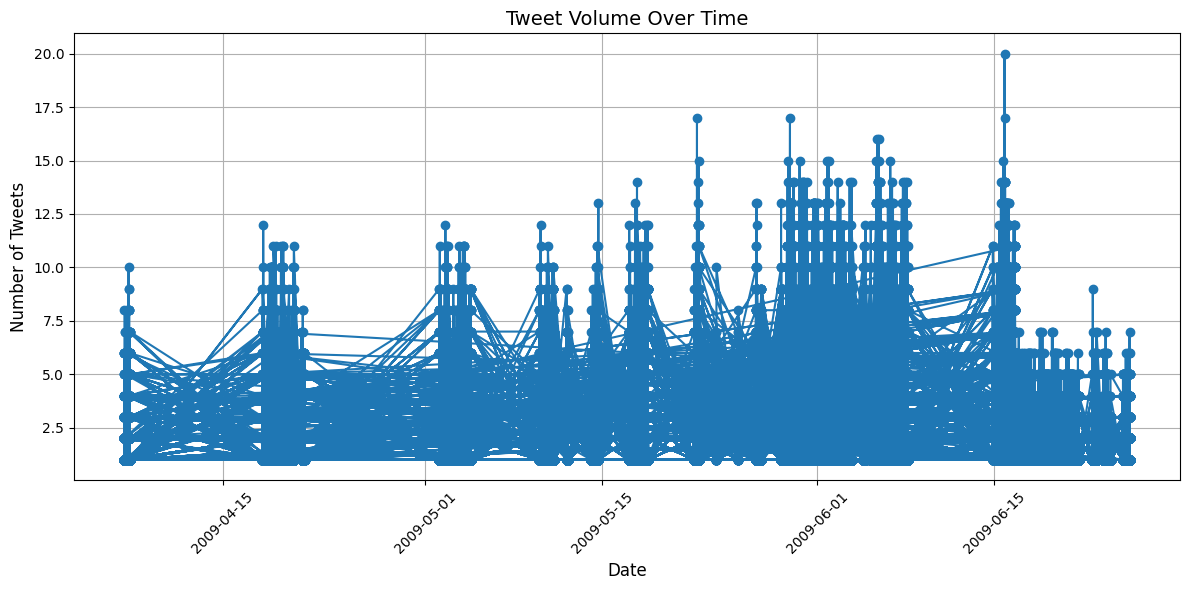

In [30]:
from pyspark.sql.functions import count

# Aggregate tweets by date
tweet_volume = df_cleaned.groupBy("timestamp").agg(count("*").alias("tweet_count"))

# Convert to Pandas for plotting
tweet_volume_pd = tweet_volume.toPandas()

# Plot tweet volume over time
plt.figure(figsize=(12, 6))
plt.plot(tweet_volume_pd["timestamp"], tweet_volume_pd["tweet_count"], marker='o')
plt.title("Tweet Volume Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


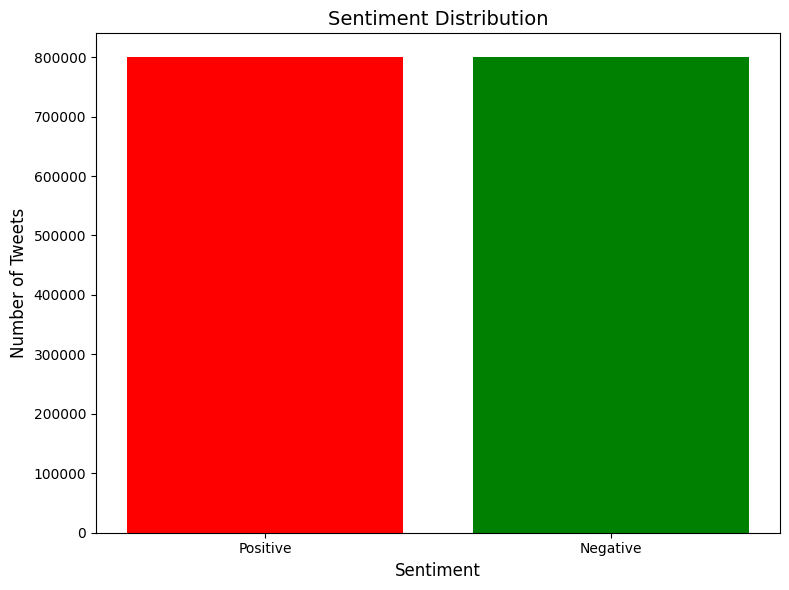

In [31]:
# Aggregate sentiment counts
sentiment_distribution = df_cleaned.groupBy("Target").count()

# Convert to Pandas for plotting
sentiment_pd = sentiment_distribution.toPandas()

# Map target labels to human-readable names
sentiment_labels = {0: "Negative", 4: "Positive"}
sentiment_pd["Sentiment"] = sentiment_pd["Target"].map(sentiment_labels)

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_pd["Sentiment"], sentiment_pd["count"], color=["red", "green"])
plt.title("Sentiment Distribution", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.tight_layout()
plt.show()


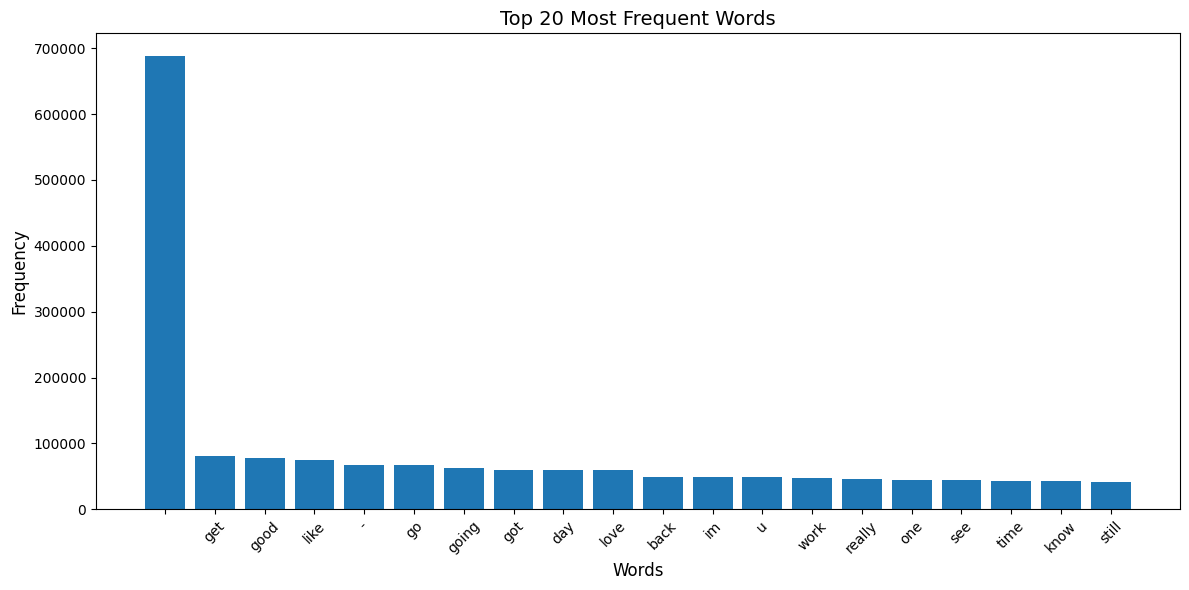

In [32]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import explode

# Tokenize the tweet text
tokenizer = Tokenizer(inputCol="OriginalTweet", outputCol="words")
df_tokenized = tokenizer.transform(df_cleaned)

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_no_stopwords = remover.transform(df_tokenized)

# Explode words into individual rows
df_exploded = df_no_stopwords.select(explode(col("filtered_words")).alias("word"))

# Count word frequencies
word_counts = df_exploded.groupBy("word").count().orderBy(col("count").desc())

# Convert to Pandas for plotting
top_words = word_counts.limit(20).toPandas()

# Plot the most frequent words
plt.figure(figsize=(12, 6))
plt.bar(top_words["word"], top_words["count"])
plt.title("Top 20 Most Frequent Words", fontsize=14)
plt.xlabel("Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [33]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Convert words to feature vectors
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")

# Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="Target", maxIter=10)

# Create a pipeline
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, lr])


In [34]:
# Split dataset into training and testing sets
train_data, test_data = df_cleaned.randomSplit([0.8, 0.2], seed=42)

# Train the pipeline model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Show predictions
predictions.select("OriginalTweet", "Target", "prediction").show(5)


+--------------------+------+----------+
|       OriginalTweet|Target|prediction|
+--------------------+------+----------+
|wishing i could b...|     0|       0.0|
|@chriswhill sweet...|     0|       4.0|
|I'm losing follow...|     0|       0.0|
|@Lorenzohenrie i ...|     0|       0.0|
|@nick_carter http...|     0|       0.0|
+--------------------+------+----------+
only showing top 5 rows

